In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from inference import ConditionalInference
from cir_dataset import CIRDataset

# === 加载标准化参数 ===
coord_stats = np.load("stats/coord_stats.npz")
coord_mean = coord_stats["mean"]
coord_std = coord_stats["std"]

cir_stats = np.load("stats/cir_stats.npz")
cir_mean = cir_stats["mean"]
cir_std = cir_stats["std"]

# === 你的真实坐标（单位 m）===
real_coord = np.array([-7.00, -1.00, 1.500])  # shape: (3,)

# 标准化后输入模型
coord_norm = (real_coord - coord_mean) / coord_std
coord_tensor = torch.tensor(coord_norm, dtype=torch.float32).unsqueeze(0)

# === 加载模型并生成 CIR ===
inference_engine = ConditionalInference(
    model_path='/tmp/pycharm_project_228/checkpoints/checkpoints_run_2_2025-03-27_23-05-16/model_epoch_1000.pth',  # 替换为你模型路径
    input_length=20,
    cond_dim=3,
    timesteps=1000
)

# 生成不同去噪阶段的 CIR（根据不同的 timesteps）
timesteps_list = [1000,500, 100, 10]
generated_cir = {}

for timesteps in timesteps_list:
    generated_cir[timesteps] = inference_engine.generate(coord_tensor, batch_size=1, x_t=timesteps)[0]
    delay = generated_cir[timesteps][:, 0] * cir_std[0] + cir_mean[0]
    amplitude = generated_cir[timesteps][:, 1] * cir_std[1] + cir_mean[1]
    phase = torch.atan2(generated_cir[timesteps][:, 3], generated_cir[timesteps][:, 2])  # sin, cos → rad
    generated_cir[timesteps] = torch.stack([delay, amplitude, phase], dim=1)

# === 可选：找真实 CIR 对比 ===
dataset = CIRDataset("data/cir_data_3.27.h5", normalize=True)

min_dist = float("inf")
real_cir = None
closest_idx = -1
threshold = 1.0  # 设置距离阈值(单位：米)

# 查找最近邻
for i in range(len(dataset)):
    coord_i, cir_i = dataset[i]
    coord_real_i = coord_i * torch.tensor(coord_std) + torch.tensor(coord_mean)
    dist = torch.norm(coord_real_i - torch.tensor(real_coord)).item()
    if dist < min_dist:
        min_dist = dist
        real_cir = cir_i
        closest_idx = i

# 添加距离检查
if min_dist > threshold:
    print(f"\n⚠️ 警告：最近样本距离{min_dist:.2f}米(超过阈值{threshold}米)，结果可能不准确")
    print(f"最近样本索引: {closest_idx}")
    print(f"最近样本坐标: {coord_real_i.tolist()}")
    print(f"目标坐标: {real_coord.tolist()}")
else:
    print(f"\n✅ 找到有效近邻，距离: {min_dist:.2f}米")

# 反标准化真实 CIR
if real_cir is not None:
    delay_r = real_cir[:, 0] * cir_std[0] + cir_mean[0]
    amp_r = real_cir[:, 1] * cir_std[1] + cir_mean[1]
    phase_r = torch.atan2(real_cir[:, 3], real_cir[:, 2])
    cir_real = torch.stack([delay_r, amp_r, phase_r], dim=1)
    print("\n📡 最接近坐标的真实 CIR:\n", cir_real)
else:
    print("\n❌ 未找到符合条件的CIR样本")
    cir_real = None

# # === 绘制不同去噪阶段的 CIR 对比图 ===
# fig, axs = plt.subplots(len(timesteps_list) + 1, 1, figsize=(12, 6 * (len(timesteps_list) + 1)))

# # 循环绘制去噪阶段的 CIR
# for idx, timesteps in enumerate(timesteps_list):
#     axs[idx].plot(generated_cir[timesteps][:, 0].cpu().numpy(), 
#                   generated_cir[timesteps][:, 1].cpu().numpy(),
#                   label=f'Denoised ({timesteps} timesteps)', alpha=0.7)
#     axs[idx].set_title(f'Denoised CIR with {timesteps} timesteps')
#     axs[idx].set_xlabel('Delay (ns)')
#     axs[idx].set_ylabel('Field Strength (dBuV/m)')
#     axs[idx].legend()
#     axs[idx].grid(True)
# 
# # 绘制真实 CIR
# axs[-1].plot(cir_real[:, 0].cpu().numpy(), cir_real[:, 1].cpu().numpy(), 'o-', label='Real CIR', color='black', alpha=0.7)
# axs[-1].set_title('Real CIR')
# axs[-1].set_xlabel('Delay (ns)')
# axs[-1].set_ylabel('Field Strength (dBuV/m)')
# axs[-1].legend()
# axs[-1].grid(True)
# 
# # 调整布局
# plt.tight_layout()
# plt.show()



[INFO] 坐标与 CIR 归一化参数已保存到 ./stats/

✅ 找到有效近邻，距离: 0.43米

📡 最接近坐标的真实 CIR:
 tensor([[205.9644,  65.1100,   2.5699],
        [182.3999,  63.9600,  -2.8262],
        [206.2722,  56.4000,   2.5715],
        [212.7095,  55.9500,  -0.2692],
        [182.8810,  55.7300,  -2.8235],
        [182.8810,  55.7300,  -2.8235],
        [183.6667,  52.6300,  -2.8475],
        [183.6667,  52.6300,  -2.8475],
        [206.3321,  49.1100,   2.5733],
        [206.3595,  48.7900,   2.5742],
        [201.5191,  47.4500,  -2.6292],
        [183.0116,  43.9600,  -2.8233],
        [183.0116,  43.9600,  -2.8233],
        [187.5630,  43.5700,  -2.8869],
        [187.5630,  43.5700,  -2.8869],
        [184.9927,  43.4000,  -2.7537],
        [182.9200,  42.4900,  -2.8182],
        [182.9200,  42.4900,  -2.8182],
        [193.5430,  40.5800,  -3.0555],
        [193.5430,  40.5800,  -3.0555]])


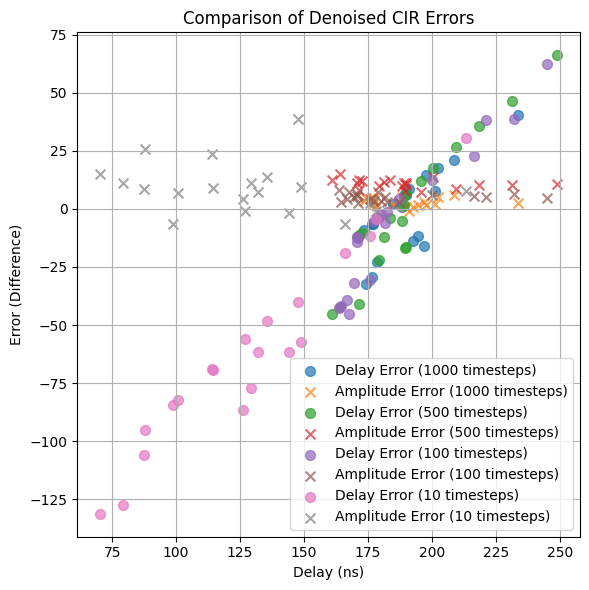

In [20]:
# === 计算并绘制误差 ===
plt.figure(figsize=(6, 6))

for timesteps in timesteps_list:
    # 计算去噪结果与真实CIR的误差
    delay_error = generated_cir[timesteps][:, 0].cpu().numpy() - cir_real[:, 0].cpu().numpy()
    amplitude_error = generated_cir[timesteps][:, 1].cpu().numpy() - cir_real[:, 1].cpu().numpy()
    
    # 只绘制误差点，不绘制线段
    plt.scatter(generated_cir[timesteps][:, 0].cpu().numpy(), delay_error, label=f'Delay Error ({timesteps} timesteps)', marker='o', s=50, alpha=0.7)
    plt.scatter(generated_cir[timesteps][:, 0].cpu().numpy(), amplitude_error, label=f'Amplitude Error ({timesteps} timesteps)', marker='x', s=50, alpha=0.7)

# 标题和标签
plt.title('Comparison of Denoised CIR Errors')
plt.xlabel('Delay (ns)')
plt.ylabel('Error (Difference)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


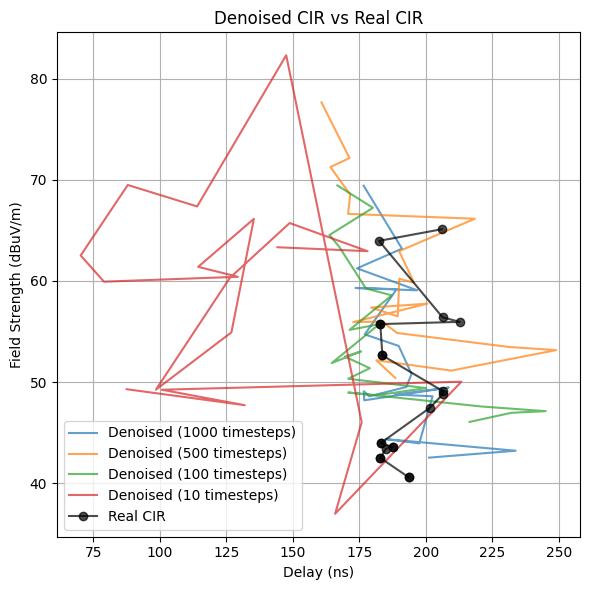

In [21]:
# === 叠加真实CIR与去噪结果 ===
plt.figure(figsize=(6, 6))

# 绘制去噪阶段的 CIR
for timesteps in timesteps_list:
    plt.plot(generated_cir[timesteps][:, 0].cpu().numpy(), 
             generated_cir[timesteps][:, 1].cpu().numpy(),
             label=f'Denoised ({timesteps} timesteps)', alpha=0.7)

# 绘制真实 CIR
plt.plot(cir_real[:, 0].cpu().numpy(), cir_real[:, 1].cpu().numpy(), 'o-', label='Real CIR', color='black', alpha=0.7)

# 标题和标签
plt.title('Denoised CIR vs Real CIR')
plt.xlabel('Delay (ns)')
plt.ylabel('Field Strength (dBuV/m)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


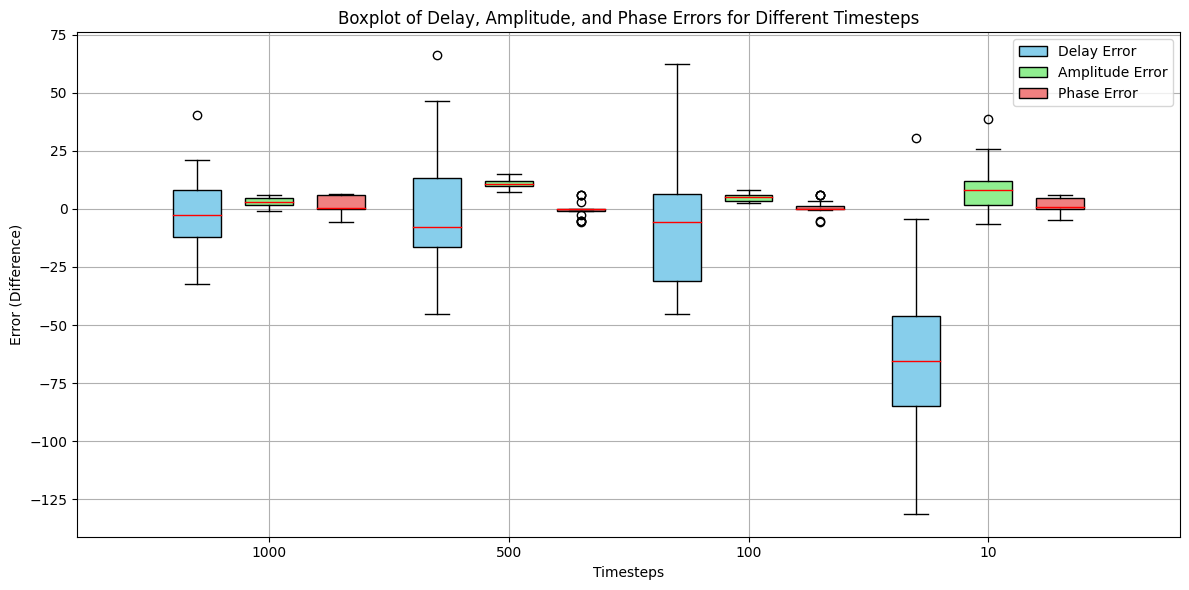

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Compute errors for delay, amplitude, and phase for each timestep
delay_errors = {
    t: generated_cir[t][:, 0].cpu().numpy() - cir_real[:, 0].cpu().numpy() 
    for t in timesteps_list
}
amplitude_errors = {
    t: generated_cir[t][:, 1].cpu().numpy() - cir_real[:, 1].cpu().numpy() 
    for t in timesteps_list
}
phase_errors = {
    t: generated_cir[t][:, 2].cpu().numpy() - cir_real[:, 2].cpu().numpy() 
    for t in timesteps_list
}

# Organize the error data for boxplot visualization
positions = np.arange(len(timesteps_list))
delay_data = [delay_errors[t] for t in timesteps_list]
amplitude_data = [amplitude_errors[t] for t in timesteps_list]
phase_data = [phase_errors[t] for t in timesteps_list]

plt.figure(figsize=(12, 6))

# Plot boxplot for delay errors, shifted to the left
bp_delay = plt.boxplot(delay_data, positions=positions - 0.3, widths=0.2, patch_artist=True,
                         boxprops=dict(facecolor='skyblue'), medianprops=dict(color='red'))

# Plot boxplot for amplitude errors, centered
bp_amplitude = plt.boxplot(amplitude_data, positions=positions, widths=0.2, patch_artist=True,
                           boxprops=dict(facecolor='lightgreen'), medianprops=dict(color='red'))

# Plot boxplot for phase errors, shifted to the right
bp_phase = plt.boxplot(phase_data, positions=positions + 0.3, widths=0.2, patch_artist=True,
                       boxprops=dict(facecolor='lightcoral'), medianprops=dict(color='red'))

plt.xticks(positions, timesteps_list)
plt.xlabel('Timesteps')
plt.ylabel('Error (Difference)')
plt.title('Boxplot of Delay, Amplitude, and Phase Errors for Different Timesteps')
plt.legend([bp_delay["boxes"][0], bp_amplitude["boxes"][0], bp_phase["boxes"][0]],
           ['Delay Error', 'Amplitude Error', 'Phase Error'], loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


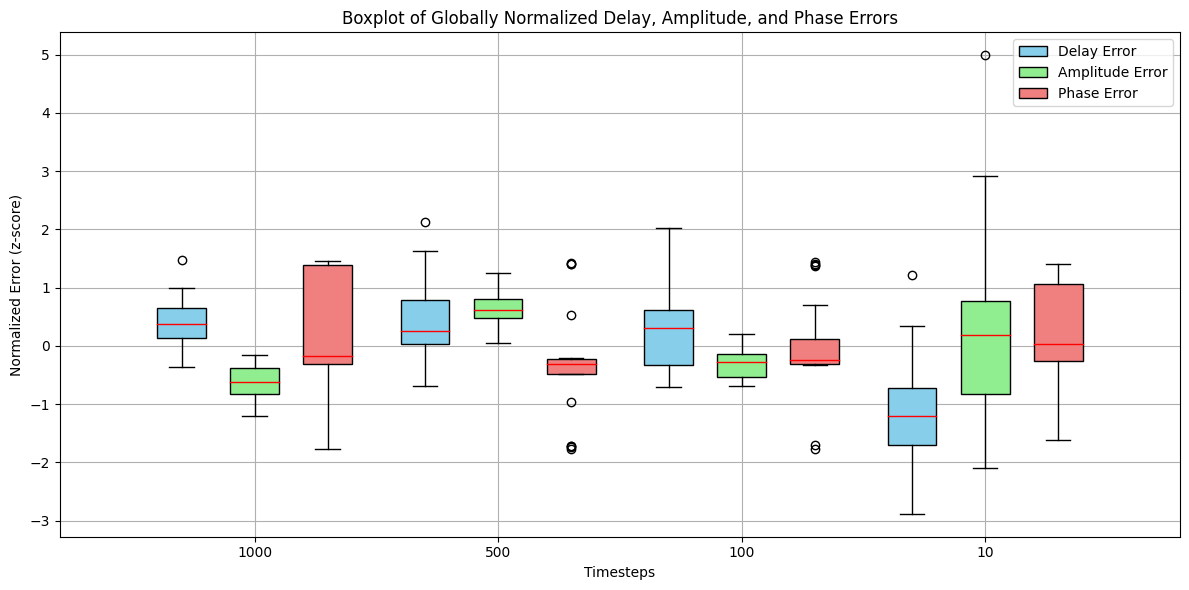

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# 计算每个时间步的误差（原始误差）
delay_errors = {t: generated_cir[t][:, 0].cpu().numpy() - cir_real[:, 0].cpu().numpy() for t in timesteps_list}
amplitude_errors = {t: generated_cir[t][:, 1].cpu().numpy() - cir_real[:, 1].cpu().numpy() for t in timesteps_list}
phase_errors = {t: generated_cir[t][:, 2].cpu().numpy() - cir_real[:, 2].cpu().numpy() for t in timesteps_list}

# 拼接所有时间步的数据，计算全局均值和标准差
all_delay = np.concatenate(list(delay_errors.values()))
all_amplitude = np.concatenate(list(amplitude_errors.values()))
all_phase = np.concatenate(list(phase_errors.values()))

# 计算全局均值与标准差
mean_delay, std_delay = np.mean(all_delay), np.std(all_delay)
mean_amplitude, std_amplitude = np.mean(all_amplitude), np.std(all_amplitude)
mean_phase, std_phase = np.mean(all_phase), np.std(all_phase)

# 全局归一化误差
norm_delay_data = [(delay_errors[t] - mean_delay) / std_delay for t in timesteps_list]
norm_amplitude_data = [(amplitude_errors[t] - mean_amplitude) / std_amplitude for t in timesteps_list]
norm_phase_data = [(phase_errors[t] - mean_phase) / std_phase for t in timesteps_list]

# 绘图
positions = np.arange(len(timesteps_list))
plt.figure(figsize=(12, 6))

bp_delay = plt.boxplot(norm_delay_data, positions=positions - 0.3, widths=0.2, patch_artist=True,
                       boxprops=dict(facecolor='skyblue'), medianprops=dict(color='red'))
bp_amplitude = plt.boxplot(norm_amplitude_data, positions=positions, widths=0.2, patch_artist=True,
                           boxprops=dict(facecolor='lightgreen'), medianprops=dict(color='red'))
bp_phase = plt.boxplot(norm_phase_data, positions=positions + 0.3, widths=0.2, patch_artist=True,
                       boxprops=dict(facecolor='lightcoral'), medianprops=dict(color='red'))

plt.xticks(positions, timesteps_list)
plt.xlabel('Timesteps')
plt.ylabel('Normalized Error (z-score)')
plt.title('Boxplot of Globally Normalized Delay, Amplitude, and Phase Errors')
plt.legend([bp_delay["boxes"][0], bp_amplitude["boxes"][0], bp_phase["boxes"][0]],
           ['Delay Error', 'Amplitude Error', 'Phase Error'], loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


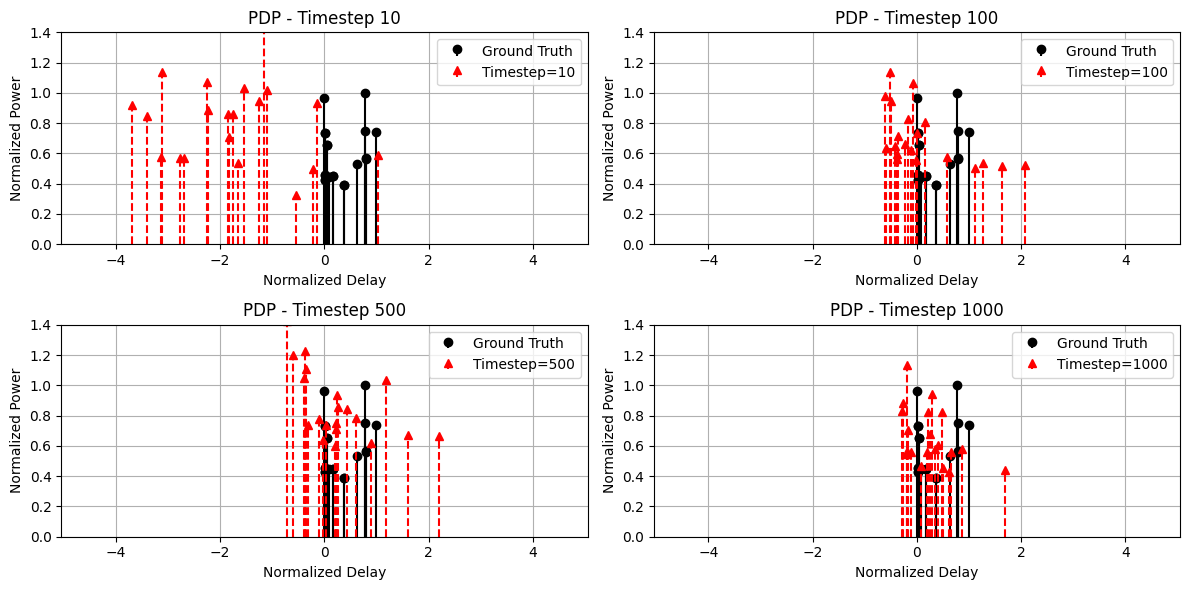

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# 假设 cir_real, generated_cir, timesteps_list 已准备好

# ==== Step 1: 计算真实 CIR 的 Delay 和 Power ====
real_delay = cir_real[:, 0].cpu().numpy()
real_amp = cir_real[:, 1].cpu().numpy()
real_power = real_amp ** 2

# ==== Step 2: 归一化参数（统一使用真实值归一化） ====
min_delay = np.min(real_delay)
max_delay = np.max(real_delay)
max_power = np.max(real_power)

# ==== Step 3: 对真实值归一化并排序 ====
real_delay_norm = (real_delay - min_delay) / (max_delay - min_delay)
real_power_norm = real_power / max_power
sort_idx = np.argsort(real_delay_norm)
real_delay_sorted = real_delay_norm[sort_idx]
real_power_sorted = real_power_norm[sort_idx]

# ==== Step 4: 准备绘图 ====
selected_timesteps = [10, 100, 500, 1000]  # 你可以改成任何子集
n_cols = 2
n_rows = int(np.ceil(len(selected_timesteps) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))
axes = axes.flatten()

# ==== Step 5: 计算统一 x 轴范围 ====
delay_min_norm = -5
delay_max_norm = 5
pad = 0.05  # 可选：左右扩展一些空间
xlim_min = delay_min_norm - pad
xlim_max = delay_max_norm + pad

# ==== Step 6: 绘图循环 ====
for i, t in enumerate(selected_timesteps):
    ax = axes[i]

    # 预测值处理
    pred_delay = generated_cir[t][:, 0].cpu().numpy()
    pred_amp = generated_cir[t][:, 1].cpu().numpy()
    pred_power = pred_amp ** 2

    pred_delay_norm = (pred_delay - min_delay) / (max_delay - min_delay)
    pred_power_norm = pred_power / max_power

    sort_pred = np.argsort(pred_delay_norm)
    pred_delay_sorted = pred_delay_norm[sort_pred]
    pred_power_sorted = pred_power_norm[sort_pred]

    # 绘图
    ax.stem(real_delay_sorted, real_power_sorted, linefmt='k-', markerfmt='ko', basefmt=" ", label='Ground Truth')
    ax.stem(pred_delay_sorted, pred_power_sorted, linefmt='r--', markerfmt='r^', basefmt=" ", label=f'Timestep={t}')

    ax.set_title(f'PDP - Timestep {t}')
    ax.set_xlabel('Normalized Delay')
    ax.set_ylabel('Normalized Power')
    ax.set_xlim(xlim_min, xlim_max)
    ax.set_ylim(0, 1.4)
    ax.grid(True)
    ax.legend(loc='upper right')

# ==== Step 7: 删除空白子图（如果有） ====
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# ==== Step 8: 展示 ====
plt.tight_layout()
plt.show()


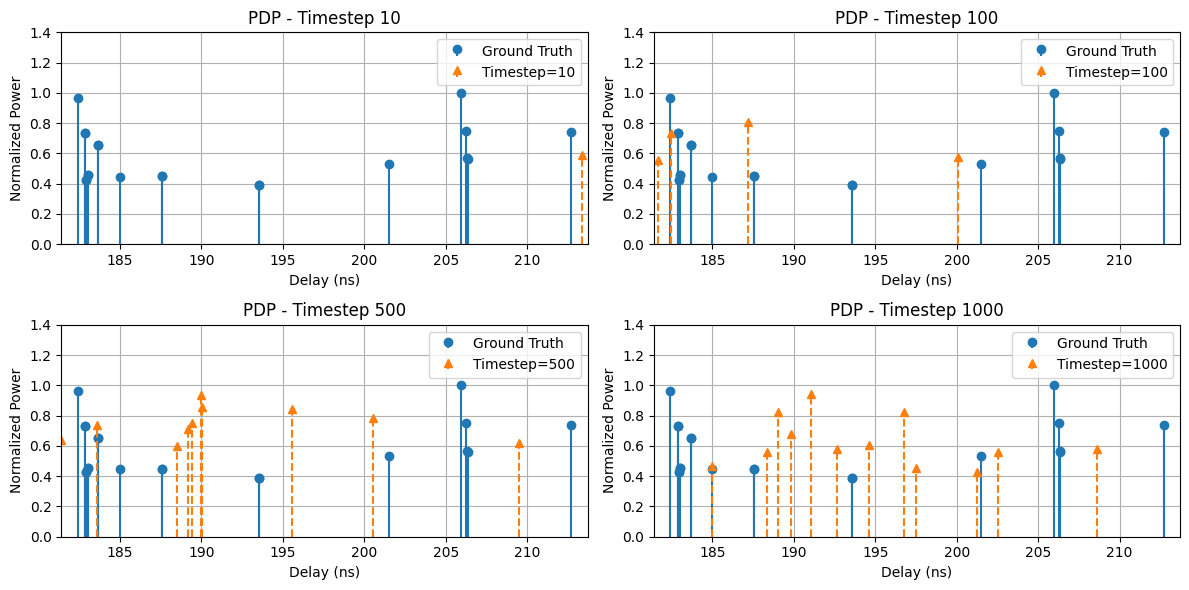

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# ==== Step 1: 计算真实 CIR 的 Delay 和 Power ====
real_delay = cir_real[:, 0].cpu().numpy()
real_amp = cir_real[:, 1].cpu().numpy()
real_power = real_amp ** 2

# ==== Step 2: Power 归一化（Delay 不归一化） ====
max_power = np.max(real_power)

real_power_norm = real_power / max_power
sort_idx = np.argsort(real_delay)
real_delay_sorted = real_delay[sort_idx]
real_power_sorted = real_power_norm[sort_idx]

# ==== Step 3: 准备绘图 ====
selected_timesteps = [10, 100, 500, 1000]
n_cols = 2
n_rows = int(np.ceil(len(selected_timesteps) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))
axes = axes.flatten()

# ==== Step 4: 设置统一 X 轴范围（真实 Delay 的最小和最大值） ====
xlim_min = np.min(real_delay) - 1
xlim_max = np.max(real_delay) + 1

# ==== Step 5: 绘图循环 ====
for i, t in enumerate(selected_timesteps):
    ax = axes[i]

    # 预测值处理（只归一化功率）
    pred_delay = generated_cir[t][:, 0].cpu().numpy()
    pred_amp = generated_cir[t][:, 1].cpu().numpy()
    pred_power = pred_amp ** 2
    pred_power_norm = pred_power / max_power

    sort_pred = np.argsort(pred_delay)
    pred_delay_sorted = pred_delay[sort_pred]
    pred_power_sorted = pred_power_norm[sort_pred]

    # ==== Ground Truth：蓝色 ====
    marker_gt, stem_gt, base_gt = ax.stem(
        real_delay_sorted, real_power_sorted,
        linefmt='-', markerfmt='o', basefmt=" ", label='Ground Truth')
    plt.setp(marker_gt, color='#1f77b4')
    plt.setp(stem_gt, color='#1f77b4')
    plt.setp(base_gt, visible=False)

    # ==== Prediction：橙色 ====
    marker_pred, stem_pred, base_pred = ax.stem(
        pred_delay_sorted, pred_power_sorted,
        linefmt='--', markerfmt='^', basefmt=" ", label=f'Timestep={t}')
    plt.setp(marker_pred, color='#ff7f0e')
    plt.setp(stem_pred, color='#ff7f0e')
    plt.setp(base_pred, visible=False)

    # 图形属性
    ax.set_title(f'PDP - Timestep {t}')
    ax.set_xlabel('Delay (ns)')
    ax.set_ylabel('Normalized Power')
    ax.set_xlim(xlim_min, xlim_max)
    ax.set_ylim(0, 1.4)
    ax.grid(True)
    ax.legend(loc='upper right')

# ==== Step 6: 删除多余子图（如果有） ====
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# ==== Step 7: 显示图 ====
plt.tight_layout()
plt.show()


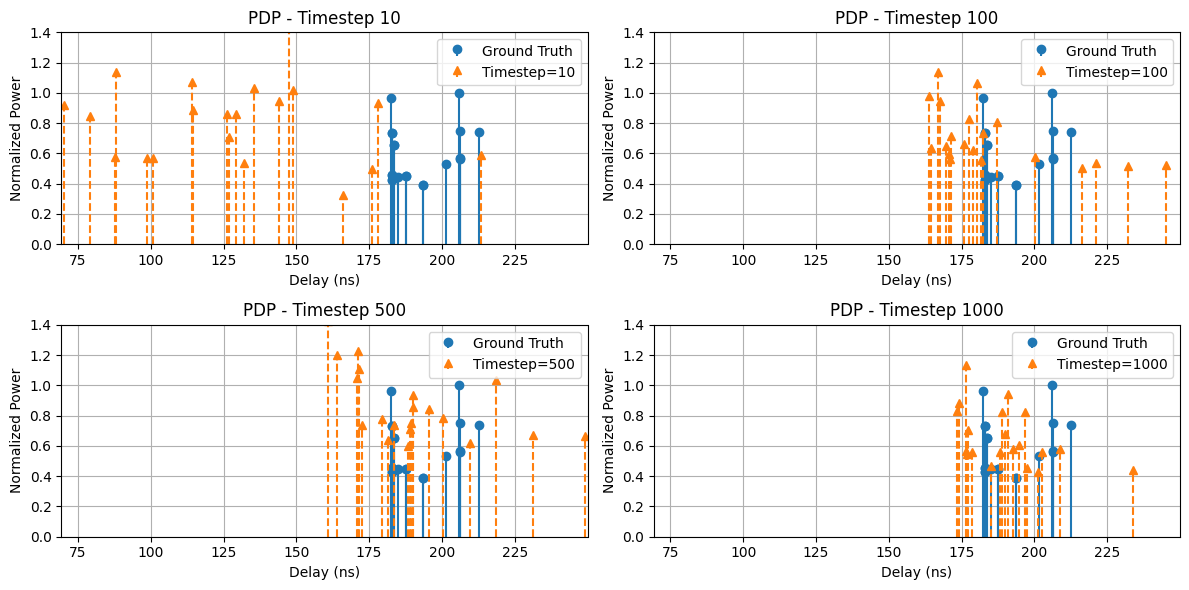

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# ==== Step 1: 计算真实 CIR 的 Delay 和 Power ====
real_delay = cir_real[:, 0].cpu().numpy()
real_amp = cir_real[:, 1].cpu().numpy()
real_power = real_amp ** 2

# ==== Step 2: Power 归一化（Delay 不归一化） ====
max_power = np.max(real_power)

real_power_norm = real_power / max_power
sort_idx = np.argsort(real_delay)
real_delay_sorted = real_delay[sort_idx]
real_power_sorted = real_power_norm[sort_idx]

# ==== Step 3: 准备绘图 ====
selected_timesteps = [10, 100, 500, 1000]
n_cols = 2
n_rows = int(np.ceil(len(selected_timesteps) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))
axes = axes.flatten()

# ==== Step 4: 以“生成值”的 delay 为准，统一 X 轴范围 ====
all_pred_delays = np.concatenate([generated_cir[t][:, 0].cpu().numpy() for t in selected_timesteps])
xlim_min = np.min(all_pred_delays) - 1
xlim_max = np.max(all_pred_delays) + 1

# ==== Step 5: 绘图循环 ====
for i, t in enumerate(selected_timesteps):
    ax = axes[i]

    # 预测值处理（只归一化功率）
    pred_delay = generated_cir[t][:, 0].cpu().numpy()
    pred_amp = generated_cir[t][:, 1].cpu().numpy()
    pred_power = pred_amp ** 2
    pred_power_norm = pred_power / max_power

    sort_pred = np.argsort(pred_delay)
    pred_delay_sorted = pred_delay[sort_pred]
    pred_power_sorted = pred_power_norm[sort_pred]

    # ==== Ground Truth（蓝色） ====
    marker_gt, stem_gt, base_gt = ax.stem(
        real_delay_sorted, real_power_sorted,
        linefmt='-', markerfmt='o', basefmt=" ", label='Ground Truth')
    plt.setp(marker_gt, color='#1f77b4')
    plt.setp(stem_gt, color='#1f77b4')
    plt.setp(base_gt, visible=False)

    # ==== Prediction（橙色） ====
    marker_pred, stem_pred, base_pred = ax.stem(
        pred_delay_sorted, pred_power_sorted,
        linefmt='--', markerfmt='^', basefmt=" ", label=f'Timestep={t}')
    plt.setp(marker_pred, color='#ff7f0e')
    plt.setp(stem_pred, color='#ff7f0e')
    plt.setp(base_pred, visible=False)

    ax.set_title(f'PDP - Timestep {t}')
    ax.set_xlabel('Delay (ns)')
    ax.set_ylabel('Normalized Power')
    ax.set_xlim(xlim_min, xlim_max)
    ax.set_ylim(0, 1.4)
    ax.grid(True)
    ax.legend(loc='upper right')

# ==== Step 6: 删除多余子图（如果有） ====
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# ==== Step 7: 显示图 ====
plt.tight_layout()
plt.show()
